In [1]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Aircraft Crash Risk 
# Individual Fatality & Crash Rate Airport Risk Assessment Framework
#
# Referenced from Byrne 1997 methodology (https://www.hse.gov.uk/research/crr_pdf/1997/crr97150.pdf)
# Adapted by Karen Barns, Ben Shao, and Mike Mieler in 2020; UAV drone addendum by Jimmy Zhang in 2022
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Jimmy-Y.Zhang@arup.com
# August 9th, 2022

In [2]:
# Mounting Directory; Ignore in Jupyter/VS Environment, only applicable for Colab Environment
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# Libraries
!pip install geopandas
import geopandas
import numpy
import csv
import math
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import MaxNLocator
from matplotlib import ticker, cm
import numpy as np
from numpy import ma
import os
import os.path
from os import path
from scipy.ndimage.interpolation import rotate
from scipy.ndimage.interpolation import shift

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 21.0 MB/s 
     |████████████████████████████████| 6.3 MB 47.8 MB/s 
     |████████████████████████████████| 16.7 MB 433 kB/s 


**USER INPUTS**

In [55]:
## User Inputs
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~+
# Output Settings
DATA_PATH = '/content/drive/MyDrive/Airport Risk/Arlington/output/'             # This DATA_PATH needs to exist already, subsequent directory commands append to this existing path
WRITE_FILE = True                                                               # Set to True to save .csv outputs of individual runway + combined runway and .png plots 
PLOT_ONLY = False                                                               # Only toggle True AFTER initial run; this allows for adjustments to final rotation/translation plot
                                                                                # > Also allows to change plot title/legend/axis properties etc. without rerunning bulky calculations

# Airport Name
AirportID = 'Arlington Municipal Airport'

# Data Center Area in square km (km^2)
DC_area = 0.012                                                                 # Typical DC size 0.012

# Runway specifics
numrunways = 1
runwaylength = [2446.203, 2446.203, 0]                                          # Distance in metersfor [first runway, second runway, ..., final runway]
angles  = [0, 23, 0]                                                            # Angles with clockwise respect to first runway (first always 0 degrees)
xoffset = [0, 600, 0]                                                           # x distance offset between first and n-th runway (to right, from centerpoint, first always 0 offset)
yoffset = [0, 500, 0]                                                           # y distance offset between first and n-th runway (upwards,  from centerpoint, first always 0 offset)
windSplits = np.array([[0.2, 0.8],[0.5, 0.5]])                                  # Wind split in each takeoff/landing direction (50/50 by default); refer to NOAA API by Jimmy-Y.Zhang@arup.com

# Grid spacing in meters (m)
contour_step = 35                                                               # Ticks/stepsize of meshgrid; start with large spacing (100m) to troubleshoot - small spacing (<20m) takes ~10min/runway

# Movements, [first runway, second runway, ..., final runway]
nm_ac = [20, 20]                                                                # air carrier movement (1 operation = landing + take-off = 2 movements)
nm_r = [1000, 1000]                                                             # regional/transient 
nm_ga = [800, 800]                                                              # general aviation
nm_m = [0, 0]                                                                   # military
nm_d = [0,0]                                                                    # UAV/drone

**FUNCTIONS**

In [56]:
## Function to calculate extent of contour given geometry of runway(s)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def contourExtent(runwaylength,contour_step,numrunways,angles):
  init_mesh = np.zeros([round(max(runwaylength)*4/contour_step),round(max(runwaylength)*8/contour_step)])
  init_shape = np.array([init_mesh.shape[0],init_mesh.shape[1]])

  for i in range(1,numrunways):
    rotate_mesh = rotate(init_mesh, angles[i], reshape=True)
    init_shape = np.append(init_shape, np.array([rotate_mesh.shape[0],rotate_mesh.shape[1]]),axis = 0)

  xlim = (max(init_shape.reshape(numrunways,2)[:,1])/2 + max(xoffset)/contour_step)*contour_step*2
  ylim = (max(init_shape.reshape(numrunways,2)[:,0])/2 + max(yoffset)/contour_step)*contour_step*2

  return xlim, ylim

In [57]:
## Function to check output folder directories
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def makeDir(index,DATA_PATH):
  if path.exists(DATA_PATH + 'runway_' + str(index)) == False:
    os.mkdir(DATA_PATH+ 'runway_' + str(index))

  os.chdir(DATA_PATH+ 'runway_' + str(index))
  !pwd
  !ls

In [58]:
## Function to save output by Ben.Shao@arup.com
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def write2csv(data, units, filename, col_labels, row_labels):
    with open(filename, 'w', newline='') as csvfile:                            
        output = csv.writer(csvfile, delimiter=',')                             
        output.writerow([units]+col_labels)                                     
        for i,row in enumerate(data):                                           
            try:
                output.writerow([row_labels[i]] + list(row))                   
            except:
                output.writerow([row_labels[i]] + [row])  

In [59]:
## Function to calculate risk contour by Ben.Shao@arup.com and Mike.Miler@arup.com
#
#  Additional drone background crash risk calibrated by Jimmy-y.Zhang@arup.com from 
#  USAF AIB, Wikileaks War Logs, and various general/military press release
#
#  Additional drone individual fatality impact area taken from median value in 
#  Lin & Shao, 2020: https://arc.aiaa.org/doi/10.2514/1.I010795
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def calcRisk(nm_ac,nm_r,nm_ga,nm_m,nm_d,Splitduetowind,runwaylength,DC_area,Lgrid,xlim,ylim,WRITE_FILE,DATA_PATH,index):
    
  # movements
  nm_tot = nm_ac + nm_r + nm_ga + nm_m

  # crash rates per movement
  cr_ac = 2.35e-7                                                               # number of air carrier crashes per movement
  cr_r  = 1.65e-6                                                               # number of regional crashes per movement
  cr_ga = 1.02e-5                                                               # number of general aviation crashes per movement
  cr_m  = 1.80e-6                                                               # number of military crashes per movement

  # background crash rates
  bcr_ac = 1.31e-7                                                              # number of crashes per sq km
  bcr_r  = 1.41e-6                                                                
  bcr_ga = 2.87e-5                                                                
  bcr_m  = 1.54e-6                                                                
  bcr_h  = 1.47e-6
  bcr_d  = 6.40e-7

  # impact areas for each aircraft category (km2)
  # assumes 100% lethality in this zone
  # various sources, see summary of data spreadsheet
  ia_ac = 2.98E-2
  ia_r  = 5.52E-3
  ia_ga = 5.52E-4
  ia_m  = 1.33E-2
  ia_h  = 5.52E-4
  ia_d  = 6.51E-2    

  xlist = list(range(int(-xlim/2),int(xlim/2),Lgrid))
  #xlist = list(range(xlim,-3275-Lgrid,-1*Lgrid))
  ylist = list(range(int(-ylim/2),int(ylim/2),Lgrid))
  #ylist = list(range(int(-ylim),int(-1*Lgrid),int(Lgrid))) + list(range(int(2*Lgrid),int(ylim+Lgrid),int(Lgrid)))   # hacky way to remove grid points along the centerline 
  grid = geopandas.GeoDataFrame()  
      
  for scenario_id in range(0,2):
      
    nrows = len(xlist)
    ncols = len(ylist)
    
    row = []
    col = []
    xvalue = []
    yvalue = []
    rvalue = []
    tvalue = []

    # Loop over each single grid points get x and y coordinate for calculation as well as r and angle for each scenario (right and left end of runway)
    for i in range(nrows):
        for j in range(ncols):
            
          row.append(i)
          col.append(j)
          xvalue.append(xlist[i])          # x coordinate for each grid point. Origin is the center of xlim defined
          yvalue.append(ylist[j])          # y coordinate for each grid point. Origin is the center of ylim defined
          
          # Recalculte the x,y coordinate use for the equation. This is for the model of general aircraft as the coordinate is defined from the end of the run way
          if scenario_id == 0:
        
            x_calc = xlist[i]-runwaylength/2
  #          x_calc0 = xlist[i]
            y_calc = ylist[j]                                           # Right side (larger coordinate side)
    
          elif scenario_id == 1:
        
            x_calc = -(xlist[i]+runwaylength/2)
  #         x_calc0 = xlist[i]
            y_calc = ylist[j]                                           # Left side (larger coordinate side)
          
          rvalue.append(math.sqrt(x_calc**2+y_calc**2))
          angle = numpy.degrees(numpy.arctan2(abs(y_calc),abs(x_calc))) 
            
          if x_calc > 0:
              tvalue.append(angle)
          else:
              tvalue.append(180.0-angle)
              
              
    grid['row'] = row
    grid['col'] = col        
    grid['x'] = xvalue
    grid['y'] = yvalue
    grid['r'] = rvalue
    grid['t'] = tvalue


    npts = len(grid['x'])
    fxyt  = numpy.zeros(npts)   # Take off risk for general method
    fxyl  = numpy.zeros(npts)   # Landing risk for general method
    fr_ga = numpy.zeros(npts)   # general aviation model

    # Calculate the actual crashing risk using the airfield model for one scenario.
    for i in range(npts):

      xi = grid['x'][i]
      yi = grid['y'][i]
      ri = grid['r'][i]
      ti = grid['t'][i]

      # x1 = xi/1000 + Lgrid/2/1000
      # y1 = yi/1000 - Lgrid/2/1000
      # x2 = xi/1000 - Lgrid/2/1000
      # y2 = yi/1000 + Lgrid/2/1000

      # General aviation equation.
      fr_ga[i] = (0.08*math.exp(-1.0*ri/2.5/1000.0) * math.exp(-1.0*ti/60.0))


      if scenario_id == 0:
        
        x_calc = xi-runwaylength/2
        #x_calc = xi
        y_calc = yi                                                                 # Right side (larger coordinate side)
    
      elif scenario_id == 1:
        
        x_calc = -(xi+runwaylength/2)
        #x_calc = xi
        y_calc = yi        
      
      if x_calc >= -600:
          fxyt[i] = ((x_calc/1000.0+0.6)/1.44
                      * math.exp(-1.0*(x_calc/1000.0+0.6)/1.2)
                      * (46.25*math.exp(-0.5*((125.0*y_calc/1000.0)**2.0))/((2.0*math.pi)**0.5)
                      + 0.9635*math.exp(-4.1*abs(y_calc/1000.0))
                      + 0.08*math.exp(-1.0*abs(y_calc/1000.0))))
          # if yi != 0:
          #     fxyti[i] = ((((-ct/bt)*(x2+at+ct)*math.exp(-1*(x2+at)/ct))
          #                 - ((-ct/bt)*(x1+at+ct)*math.exp(-1*(x1+at)/ct)))
          #                 * (dt/125 + (mt/nt)*(math.exp(-1*nt*abs(y1))-math.exp(-1*nt*abs(y2)))
          #                 + (pt/qt)*(math.exp(-1*qt*abs(y1))-math.exp(-1*qt*abs(y2)))))
          

          
          
      if x_calc >= -3275:
          fxyl[i] = ((x_calc/1000.0+3.275)/3.24
                      * math.exp(-1.0*(x_calc/1000.0+3.275)/1.8)
                      * (56.25*math.exp(-0.5*((125.0*y_calc/1000.0)**2.0))/((2.0*math.pi)**0.5)
                      + 0.625*math.exp(-1.0*abs(y_calc/1000.0)/0.4)
                      + 0.005*math.exp(-1.0*abs(y_calc/1000.0)/5.0)))
          
          #fxyl[i] = 0
          # if yi != 0:
          #     fxyli[i] = ((((-cl/bl)*(x2+al+cl)*math.exp(-1*(x2+al)/cl))      # 
          #                 - ((-cl/bl)*(x1+al+cl)*math.exp(-1*(x1+al)/cl)))
          #                 * (dl/125 + (ml/nl)*(math.exp(-1*nl*abs(y1))-math.exp(-1*nl*abs(y2)))
          #                 + (pl/ql)*(math.exp(-1*ql*abs(y1))-math.exp(-1*ql*abs(y2)))))
    # if scenario_id == 0:
    #   grid['fr_ga'] = fr_ga
    #   grid['fxyt']  = fxyt
    #   grid['fxyl']  = fxyl   
      
    # else:
    #   grid['fr_ga'] = grid['fr_ga'] + fr_ga
    #   grid['fxyt']  = grid['fxyt'] + fxyt
    #   grid['fxyl']  = grid['fxyl'] + fxyl      


    if scenario_id == 0:

      grid['fr_ga'] = fr_ga
      grid['fxyt']  = fxyt
      grid['fxyl']  = fxyl  
    
      nm_takeoff_ac = nm_ac * 0.5 * Splitduetowind[0]
      nm_land_ac = nm_ac * 0.5 * Splitduetowind[1]
      nm_takeoff_r = nm_r * 0.5 * Splitduetowind[0]
      nm_land_r = nm_r * 0.5 * Splitduetowind[1]
      nm_takeoff_ga = nm_ga * 0.5 * Splitduetowind[0]
      nm_land_ga = nm_ga * 0.5 * Splitduetowind[1]
      nm_takeoff_m = nm_m * 0.5 * Splitduetowind[0]
      nm_land_m = nm_m * 0.5 * Splitduetowind[1]
      nm_takeoff_d = nm_d * 0.5 * Splitduetowind[0]
      nm_land_d = nm_d * 0.5 * Splitduetowind[1]

    elif scenario_id == 1:
      
      grid['fr_ga'] = grid['fr_ga'] + fr_ga
      grid['fxyt']  = grid['fxyt'] + fxyt
      grid['fxyl']  = grid['fxyl'] + fxyl   
      
      nm_takeoff_ac = nm_ac * 0.5 * Splitduetowind[1]
      nm_land_ac = nm_ac * 0.5 * Splitduetowind[0]
      nm_takeoff_r = nm_r * 0.5 * Splitduetowind[1]
      nm_land_r = nm_r * 0.5 * Splitduetowind[0]
      nm_takeoff_ga = nm_ga * 0.5 * Splitduetowind[1]
      nm_land_ga = nm_ga * 0.5 * Splitduetowind[0]
      nm_takeoff_m = nm_m * 0.5 * Splitduetowind[1]
      nm_land_m = nm_m * 0.5 * Splitduetowind[0]
      nm_takeoff_d = nm_d * 0.5 * Splitduetowind[0]
      nm_land_d = nm_d * 0.5 * Splitduetowind[1]
    
  # calculate airfield crash risk = crash rate x no. movements x f(x,y)/f(r,theta)
    af_ac = cr_ac*(nm_takeoff_ac)* fxyt + cr_ac*(nm_land_ac)*fxyl
    
  # print(nm_takeoff_ga)
    
    af_r = cr_r*(nm_takeoff_r)* fxyt + cr_r*(nm_land_r)*fxyl
    #af_ga = cr_ga*(nm_takeoff_ga)* fxyt + cr_ga*(nm_land_ga)*fxyl

    # Use the simplified theta r equation for the general aviation and airtaxi
    af_ga = cr_ga*nm_ga*fr_ga
    #af_r  = cr_r*nm_r*fr_ga 


    af_m  = cr_m*(nm_takeoff_m)* fxyt + cr_m*(nm_land_m)*fxyl
    #af_m  = cr_m*nm_m*fr_ga
    af_h  = 0

    af_d  = cr_m*(nm_takeoff_d)* fxyt + cr_m*(nm_land_d)*fxyl


    if scenario_id == 0:
        
      grid['af_ac']  = af_ac
      grid['af_r']  = af_r
      grid['af_ga']  = af_ga
      grid['af_m']  = af_m
      grid['af_h']  = af_h
      grid['af_d'] = af_d

    else:
      grid['af_ac']  = grid['af_ac'] + af_ac
      grid['af_r']  = grid['af_r'] + af_r
      grid['af_ga']  = grid['af_ga'] + af_ga
      grid['af_m']  = grid['af_m'] + af_m
      grid['af_h']  = grid['af_h'] + af_h
      grid['af_d']  = grid['af_d'] + af_d

  # calculate total crash risk = airfield crash + background crash. This will be outside the secnario loop as background should only be considered once
  tcr_ac = grid['af_ac'] + bcr_ac
  tcr_r = grid['af_r'] + bcr_r
  tcr_ga = grid['af_ga'] + bcr_ga
  tcr_m = grid['af_m'] + bcr_m
  tcr_h = grid['af_h'] + bcr_h
  tcr_d = grid['af_d'] + bcr_d
  tcr = tcr_ac + tcr_r + tcr_ga + tcr_m + tcr_h + tcr_d

  # calculate crash risk for typical datacenter
  tcr = tcr_ac + tcr_r + tcr_ga + tcr_m + tcr_h                                   # total crash rate (background and airfield) for all aircraft categories (crashes / yr / km2)
  tcr_dc = tcr * DC_area                                                          # crash risk at a typical DC (crashes / yr)
  tcr_ac_dc = tcr_ac * DC_area                                                    # crash risk from ac only

  grid['tcr_ac']  = tcr_ac
  grid['tcr_r']  = tcr_r
  grid['tcr_ga']  = tcr_ga
  grid['tcr_m']  = tcr_m
  grid['tcr_h']  = tcr_h
  grid['tcr_d']  = tcr_d
  grid['tcr']  = tcr
  grid['tcr_dc']  = tcr_dc
  grid['tcr_ac_dc']  = tcr_ac_dc

  # calculate individual fatality = tcr * ia
  ir_ac = tcr_ac * ia_ac
  ir_r = tcr_r * ia_r
  ir_ga = tcr_ga * ia_ga
  ir_m = tcr_m * ia_m
  ir_h = tcr_h * ia_h
  ir_d = tcr_d * ia_d
  ir_total = ir_ac + ir_r + ir_ga + ir_m + ir_h + ir_d
  max_ir = max(ir_total)
  min_ir = min(ir_total)

  grid['ir_ac']  = ir_ac
  grid['ir_r']   = ir_r
  grid['ir_ga']  = ir_ga
  grid['ir_m']   = ir_m
  grid['ir_h']   = ir_h
  grid['ir_d']   = ir_d
  grid['ir_total']  = ir_total

  # print(grid)

  output_x      = numpy.zeros((nrows,ncols))
  output_y      = numpy.zeros((nrows,ncols))
  output_r      = numpy.zeros((nrows,ncols))
  output_t      = numpy.zeros((nrows,ncols))
  output_fxyt   = numpy.zeros((nrows,ncols))
  output_fxyl   = numpy.zeros((nrows,ncols))
  output_fr_ga  = numpy.zeros((nrows,ncols))
  # output_fxyti = numpy.zeros((nrows,ncols))
  # output_fxyli = numpy.zeros((nrows,ncols))
  output_af_ac  = numpy.zeros((nrows,ncols))
  output_af_r   = numpy.zeros((nrows,ncols))
  output_af_ga  = numpy.zeros((nrows,ncols))
  output_af_m   = numpy.zeros((nrows,ncols))
  output_af_h   = numpy.zeros((nrows,ncols))
  output_af_d   = numpy.zeros((nrows,ncols))
  output_ir_ac  = numpy.zeros((nrows,ncols))
  output_ir_r   = numpy.zeros((nrows,ncols))
  output_ir_ga  = numpy.zeros((nrows,ncols))
  output_ir_m   = numpy.zeros((nrows,ncols))
  output_ir_h   = numpy.zeros((nrows,ncols))
  output_ir_d   = numpy.zeros((nrows,ncols))
  output_ir_total  = numpy.zeros((nrows,ncols))
  output_tcr_ac = numpy.zeros((nrows,ncols))
  output_tcr_r  = numpy.zeros((nrows,ncols))
  output_tcr_ga = numpy.zeros((nrows,ncols))
  output_tcr_m  = numpy.zeros((nrows,ncols))
  output_tcr_h  = numpy.zeros((nrows,ncols))
  output_tcr_d  = numpy.zeros((nrows,ncols))
  output_tcr    = numpy.zeros((nrows,ncols))
  output_tcr_dc = numpy.zeros((nrows,ncols))
  output_tcr_ac_dc = numpy.zeros((nrows,ncols))

  for i in range(npts):
      ii = grid['row'][i]
      ji = grid['col'][i]
      output_x[ii,ji]     = grid['x'][i]
      output_y[ii,ji]     = grid['y'][i]
      output_r[ii,ji]     = grid['r'][i]
      output_t[ii,ji]     = grid['t'][i]
      output_fxyt[ii,ji]  = grid['fxyt'][i]
      output_fxyl[ii,ji]  = grid['fxyl'][i]
      output_fr_ga[ii,ji] = grid['fr_ga'][i]
      output_af_ac[ii,ji] = grid['af_ac'][i]
      output_af_r[ii,ji] = grid['af_r'][i]
      output_af_ga[ii,ji] = grid['af_ga'][i]
      output_af_m[ii,ji] = grid['af_m'][i]
      output_af_h[ii,ji] = grid['af_h'][i]
      output_af_d[ii,ji] = grid['af_d'][i]
      # output_fxyti[ii,ji] = grid['fxyti'][i]
      # output_fxyli[ii,ji] = grid['fxyli'][i]
      output_ir_ac[ii,ji] = grid['ir_ac'][i]
      output_ir_r[ii,ji] = grid['ir_r'][i]
      output_ir_ga[ii,ji] = grid['ir_ga'][i]
      output_ir_m[ii,ji] = grid['ir_m'][i]
      output_ir_h[ii,ji] = grid['ir_h'][i]
      output_ir_d[ii,ji] = grid['ir_d'][i]
      output_ir_total[ii,ji] = grid['ir_total'][i]
      output_tcr_ac[ii,ji] = grid['tcr_ac'][i]
      output_tcr_r[ii,ji] = grid['tcr_r'][i]
      output_tcr_ga[ii,ji] = grid['tcr_ga'][i]
      output_tcr_m[ii,ji] = grid['tcr_m'][i]
      output_tcr_h[ii,ji] = grid['tcr_h'][i]
      output_tcr_h[ii,ji] = grid['tcr_d'][i]
      output_tcr[ii,ji] = grid['tcr'][i]
      output_tcr_dc[ii,ji] = grid['tcr_dc'][i]
      output_tcr_ac_dc[ii,ji] = grid['tcr_ac_dc'][i]
    
  # Evaluate crash risk (Z1) and individual risk (Z2)
  X = numpy.transpose(output_x)
  Y = numpy.transpose(output_y)
  Z1 = numpy.transpose(output_tcr_dc)                                           # Total Crash Risk
  Z2 = numpy.transpose(output_ir_total)                                         # Total Individual Risk (Fatality)

  # Export outputs
  if WRITE_FILE == True:
    makeDir(index,DATA_PATH)
    write2csv(output_r,'(meters)',DATA_PATH+ 'runway_' + str(index) +'/' + 'run_' + str(index) + '_r.csv',ylist,xlist)
    write2csv(output_t,'(degrees)',DATA_PATH+ 'runway_' + str(index) +'/' + 'run_' + str(index) + '_theta.csv',ylist,xlist)
    write2csv(output_fxyt,'(freq per km2)',DATA_PATH+ 'runway_' + str(index) +'/' + 'run_' + str(index) + '_fxyt.csv',ylist,xlist)
    write2csv(output_fxyl,'(freq per km2)',DATA_PATH+ 'runway_' + str(index) +'/' + 'run_' + str(index) + '_fxyl.csv',ylist,xlist)
    write2csv(output_fr_ga,'(freq per km2)',DATA_PATH+ 'runway_' + str(index) +'/' + 'run_' + str(index) + '_fr_ga.csv',ylist,xlist)
    # write2csv(output_fxyti,'(freq)',subdir+'test_fxyti.csv',ylist,xlist)
    # write2csv(output_fxyli,'(freq)',subdir+'test_fxyli.csv',ylist,xlist)
    write2csv(output_af_ac,'(crashes per km2)',DATA_PATH+ 'runway_' + str(index) +'/' + 'run_' + str(index) + '_af_ac.csv',ylist,xlist)
    write2csv(output_af_r,'(crashes per km2)',DATA_PATH+ 'runway_' + str(index) +'/' + 'run_' + str(index) + '_af_r.csv',ylist,xlist)
    write2csv(output_af_ga,'(crashes per km2)',DATA_PATH+ 'runway_' + str(index) +'/' + 'run_' + str(index) + '_af_ga.csv',ylist,xlist)
    write2csv(output_af_m,'(crashes per km2)',DATA_PATH+ 'runway_' + str(index) +'/' + 'run_' + str(index) + '_af_m.csv',ylist,xlist)
    write2csv(output_af_h,'(crashes per km2)',DATA_PATH+ 'runway_' + str(index) +'/' + 'run_' + str(index) + '_af_h.csv',ylist,xlist)
    write2csv(output_af_d,'(crashes per km2)',DATA_PATH+ 'runway_' + str(index) +'/' + 'run_' + str(index) + '_af_d.csv',ylist,xlist)
    write2csv(output_tcr_dc,'(crashes per year)',DATA_PATH+ 'runway_' + str(index) +'/' + 'run_' + str(index) + '_tcr_dc.csv',ylist,xlist)
    write2csv(output_ir_ac,'(fatalities per year)',DATA_PATH+ 'runway_' + str(index) +'/' + 'run_' + str(index) + '_ir_ac.csv',ylist,xlist)
    write2csv(output_ir_r,'(fatalities per year)',DATA_PATH+ 'runway_' + str(index) +'/' + 'run_' + str(index) + '_ir_r.csv',ylist,xlist)
    write2csv(output_ir_ga,'(fatalities per year)',DATA_PATH+ 'runway_' + str(index) +'/' + 'run_' + str(index) + '_ir_ga.csv',ylist,xlist)
    write2csv(output_ir_m,'(fatalities per year)',DATA_PATH+ 'runway_' + str(index) +'/' + 'run_' + str(index) + '_ir_m.csv',ylist,xlist)
    write2csv(output_ir_h,'(fatalities per year)',DATA_PATH+ 'runway_' + str(index) +'/' + 'run_' + str(index) + '_ir_h.csv',ylist,xlist)
    write2csv(output_ir_d,'(fatalities per year)',DATA_PATH+ 'runway_' + str(index) +'/' + 'run_' + str(index) + '_ir_d.csv',ylist,xlist)
    write2csv(output_ir_total,'(fatalities per year)',DATA_PATH+ 'runway_' + str(index) +'/' + 'run_' + str(index) + '_ir_total.csv',ylist,xlist)

  return X, Y, Z1, Z2

**MAIN CODE**

In [60]:
## MAIN
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Establish contour extent
xlim, ylim = contourExtent(runwaylength,contour_step,numrunways,angles)

if PLOT_ONLY == False: # THIS PART CAN TAKE 30 MINUTES IF MULTIPLE RUNWAYS, MAKE SURE TO CHECK IF PLOT_ONLY FLAG IS PROPERLY CHECKED!
  # Initiate first runway
  X, Y, crash_risk, indi_risk = calcRisk(nm_ac[0], nm_r[0], nm_ga[0], nm_m[0], nm_d[0], windSplits[0,:], runwaylength[0], DC_area, contour_step, xlim, ylim, WRITE_FILE, DATA_PATH, 1)

  # Process other runways
  if numrunways > 1:
    for i in range(1,numrunways):
      empty1, empty2, crash_new, indi_new = calcRisk(nm_ac[i], nm_r[i], nm_ga[i], nm_m[i], nm_d[i], windSplits[i,:], runwaylength[i], DC_area, contour_step, xlim, ylim, WRITE_FILE, DATA_PATH, i+1)
      crash_risk = np.append(crash_risk, crash_new, axis = 0)
      indi_risk = np.append(indi_risk, indi_new, axis = 0)

/content/drive/MyDrive/Airport Risk/Arlington/output/runway_1
run_1_af_ac.csv  run_1_crash.png  run_1_ir_ga.csv     run_1_r.csv
run_1_af_d.csv	 run_1_fr_ga.csv  run_1_ir_h.csv      run_1_tcr_dc.csv
run_1_af_ga.csv  run_1_fxyl.csv   run_1_ir_m.csv      run_1_theta.csv
run_1_af_h.csv	 run_1_fxyt.csv   run_1_IR.png
run_1_af_m.csv	 run_1_ir_ac.csv  run_1_ir_r.csv
run_1_af_r.csv	 run_1_ir_d.csv   run_1_ir_total.csv


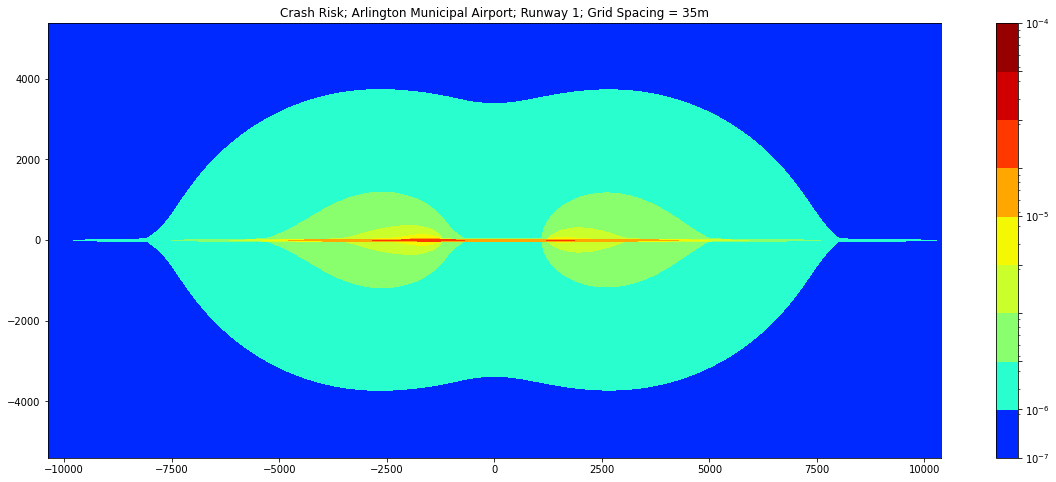

In [64]:
# Plotting Crash Risk Contour Separately
for i in range(0,numrunways):
  levels = [1e-7,1e-6,2.5e-6,5e-6,7.5e-6,1e-5,2.5e-5,5e-5,7.5e-5,1e-4]
  #levels = MaxNLocator(nbins=10).tick_values(1e-8, Z.max())
  fig, ax = plt.subplots(figsize=(20,8))
  #cs = ax.contourf(X, Y, Z, levels, cmap='jet')
  cs = ax.contourf(X, Y, crash_risk[0+X.shape[0]*(i):0+X.shape[0]*(i+1),:], levels, locator=ticker.LogLocator(), cmap='jet')
  ax.set_title('Crash Risk; ' + AirportID + '; Runway ' + str(i+1) +'; Grid Spacing = ' +  str(contour_step) + 'm')
  #ax.set_aspect('equal')
  cbar = fig.colorbar(cs)

  if WRITE_FILE == True:
    plt.savefig(DATA_PATH+ 'runway_' + str(i+1) +'/' + 'run_' + str(i+1) + '_crash.png')

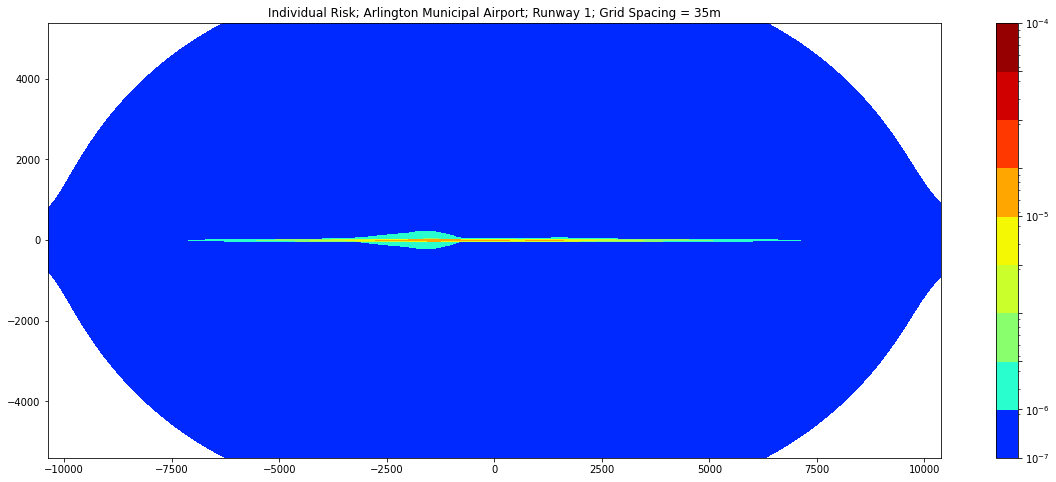

In [65]:
# Plotting Individual Risk Contour Separately
for i in range(0,numrunways):
  levels = [1e-7,1e-6,2.5e-6,5e-6,7.5e-6,1e-5,2.5e-5,5e-5,7.5e-5,1e-4]
  #levels = MaxNLocator(nbins=10).tick_values(1e-8, Z.max())
  fig, ax = plt.subplots(figsize=(20,8))
  #cs = ax.contourf(X, Y, Z, levels, cmap='jet')
  cs = ax.contourf(X, Y, indi_risk[0+X.shape[0]*(i):0+X.shape[0]*(i+1),:], levels, locator=ticker.LogLocator(), cmap='jet')
  #ax.set_title('Individual risk; ' + airport_size + ' airport; L = ' +  str(Lgrid) + 'm')
  ax.set_title('Individual Risk; ' + AirportID + '; Runway ' + str(i+1) +'; Grid Spacing = ' +  str(contour_step) + 'm')
  #ax.set_aspect('equal')
  cbar = fig.colorbar(cs)

  if WRITE_FILE == True:
    plt.savefig(DATA_PATH+ 'runway_' + str(i+1) +'/' + 'run_' + str(i+1) + '_IR.png')

In [66]:
# Overlaying and Shifting + Export
combined_crash = crash_risk[0+X.shape[0]*(0):0+X.shape[0]*(0+1)].copy()
combined_indi  =  indi_risk[0+X.shape[0]*(0):0+X.shape[0]*(0+1)].copy()

for i in range(1,numrunways):
  overlay_crash = rotate(crash_risk[0+X.shape[0]*(i):0+X.shape[0]*(i+1)], angles[i], reshape=False, order=1, mode='nearest')
  overlay_crash = shift(overlay_crash, (yoffset[i]/contour_step, xoffset[i]/contour_step), order=3, mode='nearest', prefilter=True)
  overlay_indi  = rotate(indi_risk[0+X.shape[0]*(i):0+X.shape[0]*(i+1)], angles[i], reshape=False, order=1, mode='nearest')
  overlay_indi  = shift(overlay_indi, (yoffset[i]/contour_step, xoffset[i]/contour_step), order=3, mode='nearest', prefilter=True)
  combined_crash += overlay_crash
  combined_indi  += overlay_indi

if WRITE_FILE == True:
    xlist = list(range(int(-xlim/2),int(xlim/2),contour_step))
    ylist = list(range(int(-ylim/2),int(ylim/2),contour_step))
    makeDir('combined',DATA_PATH)
    write2csv(numpy.transpose(combined_crash), '(crashes per year)', DATA_PATH + 'runway_combined/combined_tcr_dc.csv', ylist, xlist)
    write2csv(numpy.transpose(combined_indi), '(fatalities per year)', DATA_PATH + 'runway_combined/combined_ir_total.csv', ylist, xlist)

/content/drive/MyDrive/Airport Risk/Arlington/output/runway_combined
combined__crash.png  combined_ir_total.csv
combined__IR.png     combined_tcr_dc.csv


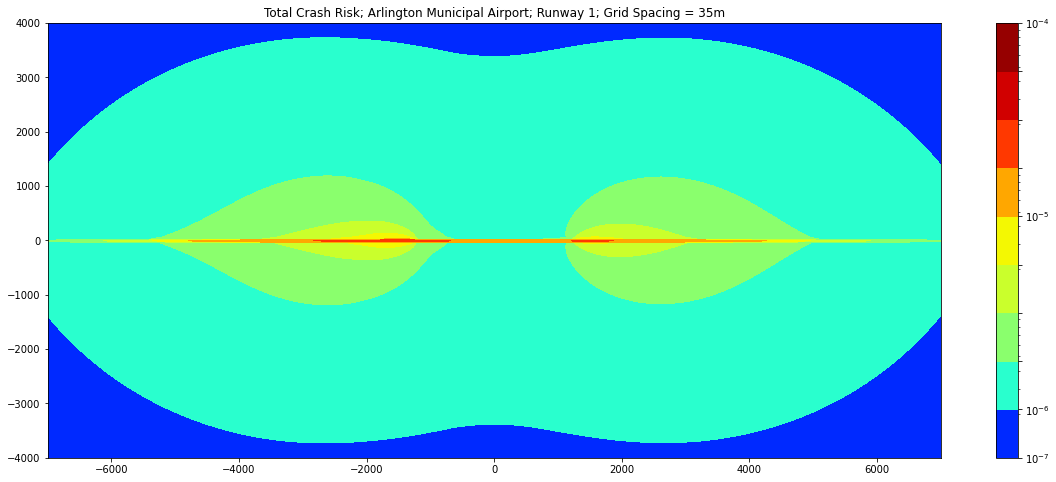

In [67]:
# Plotting Final Overlaid Crash Risk
levels = [1e-7,1e-6,2.5e-6, 5e-6, 7.5e-6,1e-5,2.5e-5,5e-5,7.5e-5,1e-4]
#levels = MaxNLocator(nbins=10).tick_values(1e-8, Z.max())
fig, ax = plt.subplots(figsize=(20,8))
#cs = ax.contourf(X, Y, Z, levels, cmap='jet')
cs = ax.contourf(X, Y, combined_crash, levels, locator=ticker.LogLocator(), cmap='jet')
#ax.set_title('Crash risk; ' + airport_size + ' airport; L = ' +  str(Lgrid) + 'm')
ax.set_title('Total Crash Risk; ' + AirportID + '; Runway ' + str(i+1) +'; Grid Spacing = ' +  str(contour_step) + 'm')
#ax.set_aspect('equal')
cbar = fig.colorbar(cs)
plt.ylim(ymax = 4000, ymin = -4000)
plt.xlim(xmax = 7000, xmin = -7000)

if WRITE_FILE == True:
  plt.savefig(DATA_PATH + 'runway_combined/combined__crash.png')

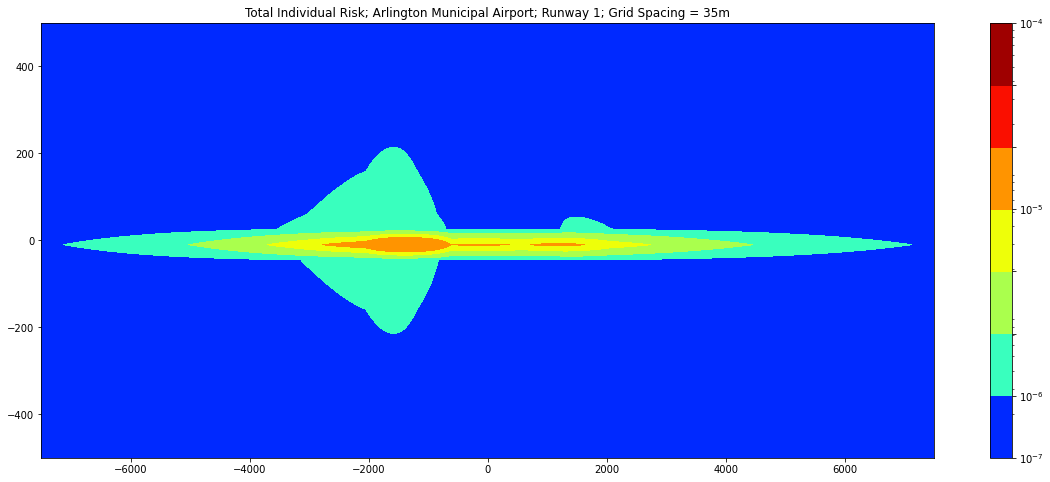

In [68]:
# Plotting Final Overlayed Individual Risk
levels = [1e-7, 1e-6,3.33e-6, 6.67e-6, 1e-5,3.33e-5,6.67e-5,1e-4]
#levels = MaxNLocator(nbins=10).tick_values(1e-8, Z.max())
fig, ax = plt.subplots(figsize=(20,8))
#cs = ax.contourf(X, Y, Z, levels, cmap='jet')
cs = ax.contourf(X, Y, combined_indi, levels, locator=ticker.LogLocator(), cmap='jet')
#ax.set_title('Individual risk; ' + airport_size + ' airport; L = ' +  str(Lgrid) + 'm')
ax.set_title('Total Individual Risk; ' + AirportID + '; Runway ' + str(i+1) +'; Grid Spacing = ' +  str(contour_step) + 'm')
#ax.set_aspect('equal')
cbar = fig.colorbar(cs)
plt.ylim(ymax = 500, ymin = -500)
plt.xlim(xmax = 7500, xmin = -7500)

if WRITE_FILE == True:
  plt.savefig(DATA_PATH + 'runway_combined/combined__IR.png')